In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class MalariaDataset(Dataset):
    def __init__(self, image_paths, labels, patient_ids, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.patient_ids = patient_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
def collect_images(infected_dir, uninfected_dir):
    image_paths = []
    labels = []
    patient_ids = []

    # Collect infected images from All_PvTk subfolders
    print("Collecting infected images...")
    infected_count = 0
    for root, dirs, files in os.walk(infected_dir):
        for f in files:
            if f.endswith('.jpg'):
                img_path = os.path.join(root, f)

                patient_name = os.path.basename(root)
                print(f"Infected image: {img_path}, Patient: {patient_name}")
                image_paths.append(img_path)
                labels.append(1)
                patient_ids.append(patient_name)
                infected_count += 1
        if files:
            print(f"Found {len(files)} files in {root}")

    # Collect uninfected images from Uninfected Patients subfolders
    print("\nCollecting uninfected images...")
    uninfected_count = 0
    for root, dirs, files in os.walk(uninfected_dir):
        for f in files:
            if f.endswith('.tiff'):
                img_path = os.path.join(root, f)
                """ Extract patient ID by navigating to the parent folder of 'tiled'
                Example path: .../Uninfected Patients/TF201_HT6/tiled/image.tiff"""
                path_parts = root.split(os.sep)
                if 'tiled' in path_parts:

                    tiled_idx = path_parts.index('tiled')
                    patient_name = path_parts[tiled_idx - 1]
                else:
                    # Fallback if 'tiled' is not found in the path
                    patient_name = os.path.basename(os.path.dirname(root))
                print(f"Uninfected image: {img_path}, Patient: {patient_name}")
                image_paths.append(img_path)
                labels.append(0)  # uninfected
                patient_ids.append(patient_name)
                uninfected_count += 1
        if files:
            print(f"Found {len(files)} files in {root}")


    print("\nSummary:")
    print(f"Total infected images collected: {infected_count}")
    print(f"Total uninfected images collected: {uninfected_count}")
    print(f"Total images collected: {len(image_paths)}")
    print(f"Unique patient IDs: {len(set(patient_ids))} ({set(patient_ids)})")
    return image_paths, labels, patient_ids

def patient_based_split(image_paths, labels, patient_ids, train_ratio=0.7, val_ratio=0.15):
    patient_to_images = defaultdict(list)
    for img_path, label, pid in zip(image_paths, labels, patient_ids):
        patient_to_images[pid].append((img_path, label))

    patients = list(patient_to_images.keys())
    print(f"Number of unique patients: {len(patients)}")
    if len(patients) < 2:
        raise ValueError("Not enough unique patients to split the dataset. Need at least 2 patients.")

    train_patients, temp_patients = train_test_split(patients, train_size=train_ratio, random_state=42)
    val_patients, test_patients = train_test_split(temp_patients, train_size=val_ratio/(1-train_ratio), random_state=42)

    train_images, train_labels, train_pids = [], [], []
    val_images, val_labels, val_pids = [], [], []
    test_images, test_labels, test_pids = [], [], []

    for pid in train_patients:
        for img_path, label in patient_to_images[pid]:
            train_images.append(img_path)
            train_labels.append(label)
            train_pids.append(pid)
    for pid in val_patients:
        for img_path, label in patient_to_images[pid]:
            val_images.append(img_path)
            val_labels.append(label)
            val_pids.append(pid)
    for pid in test_patients:
        for img_path, label in patient_to_images[pid]:
            test_images.append(img_path)
            test_labels.append(label)
            test_pids.append(pid)

    return (train_images, train_labels, train_pids), (val_images, val_labels, val_pids), (test_images, test_labels, test_pids)

In [5]:
def collect_images(infected_dir, uninfected_dir):
    """
    Collect images from infected and uninfected directories and assign patient IDs.

    Args:
        infected_dir (str): Path to the directory containing infected images.
        uninfected_dir (str): Path to the directory containing uninfected images.

    Returns:
        tuple: Lists of image paths, labels, and patient IDs.
    """
    image_paths = []
    labels = []
    patient_ids = []

    print("Collecting infected images...")
    infected_count = 0
    for root, dirs, files in os.walk(infected_dir):
        if os.path.basename(root) in [f'PvTk{i}' for i in range(1, 151)]:
            for f in files:
                if f.lower().endswith(('.jpg', '.jpeg')):
                    img_path = os.path.join(root, f)
                    patient_name = os.path.basename(root)
                    print(f"Infected image: {img_path}, Patient: {patient_name}")
                    image_paths.append(img_path)
                    labels.append(1)
                    patient_ids.append(patient_name)
                    infected_count += 1
            if files:
                print(f"Found {len(files)} files in {root}")

    print("\nCollecting uninfected images...")
    uninfected_count = 0
    for root, dirs, files in os.walk(uninfected_dir):
        path_parts = root.split(os.sep)
        if 'tiled' in path_parts:
            tiled_idx = path_parts.index('tiled')
            patient_name = path_parts[tiled_idx - 1]
            for f in files:
                if f.lower().endswith(('.tiff', '.tif')):
                    img_path = os.path.join(root, f)
                    print(f"Uninfected image: {img_path}, Patient: {patient_name}")
                    image_paths.append(img_path)
                    labels.append(0)
                    patient_ids.append(patient_name)
                    uninfected_count += 1
            if files:
                print(f"Found {len(files)} files in {root}")

    print("\nSummary:")
    print(f"Total infected images collected: {infected_count}")
    print(f"Total uninfected images collected: {uninfected_count}")
    print(f"Total images collected: {len(image_paths)}")
    print(f"Unique patient IDs: {len(set(patient_ids))} ({set(patient_ids)})")
    return image_paths, labels, patient_ids

def patient_based_split(image_paths, labels, patient_ids, train_ratio=0.7, val_ratio=0.15):
    """
    Split the dataset into training, validation, and test sets based on patients.

    Args:
        image_paths (list): List of image file paths.
        labels (list): List of labels (1 for infected, 0 for uninfected).
        patient_ids (list): List of patient IDs.
        train_ratio (float): Proportion of patients for the training set.
        val_ratio (float): Proportion of patients for the validation set.

    Returns:
        tuple: Training, validation, and test sets (images, labels, patient IDs).
    """
    patient_to_images = defaultdict(list)
    for img_path, label, pid in zip(image_paths, labels, patient_ids):
        patient_to_images[pid].append((img_path, label))

    patients = list(patient_to_images.keys())
    print(f"Number of unique patients: {len(patients)}")
    if len(patients) < 2:
        raise ValueError("Not enough unique patients to split the dataset. Need at least 2 patients.")

    # Adjust ratios to ensure non-empty train and val sets
    total_patients = len(patients)
    if total_patients == 2:
        train_ratio = 0.5
        val_ratio = 0.5
    elif total_patients == 3:
        train_ratio = 0.5
        val_ratio = 0.25
    elif total_patients <= 5:
        train_ratio = 0.6
        val_ratio = 0.2

    train_patients, temp_patients = train_test_split(patients, train_size=train_ratio, random_state=42)
    val_patients, test_patients = train_test_split(temp_patients, train_size=val_ratio/(1-train_ratio) if temp_patients else 0, random_state=42)

    train_images, train_labels, train_pids = [], [], []
    val_images, val_labels, val_pids = [], [], []
    test_images, test_labels, test_pids = [], [], []

    for pid in train_patients:
        for img_path, label in patient_to_images[pid]:
            train_images.append(img_path)
            train_labels.append(label)
            train_pids.append(pid)
    for pid in val_patients:
        for img_path, label in patient_to_images[pid]:
            val_images.append(img_path)
            val_labels.append(label)
            val_pids.append(pid)
    for pid in test_patients:
        for img_path, label in patient_to_images[pid]:
            test_images.append(img_path)
            test_labels.append(label)
            test_pids.append(pid)

    return (train_images, train_labels, train_pids), (val_images, val_labels, val_pids), (test_images, test_labels, test_pids)

In [7]:
infected_dir = r'/content/drive/MyDrive/case/NIH-NLM-ThickBloodSmearsPV'
uninfected_dir = r'/content/drive/MyDrive/case/NIH-NLM-ThickBloodSmearsU/Uninfected Patients'

print("Infected directory exists:", os.path.exists(infected_dir))
print("Uninfected directory exists:", os.path.exists(uninfected_dir))

print("\nSubdirectories in infected_dir:")
for root, dirs, files in os.walk(infected_dir):
    print(f"Root: {root}")
    print(f"Subdirs: {dirs}")
    print(f"Files: {files[:5]} (showing first 5 files)")
    break

print("\nSubdirectories in uninfected_dir:")
for root, dirs, files in os.walk(uninfected_dir):
    print(f"Root: {root}")
    print(f"Subdirs: {dirs}")
    print(f"Files: {files[:5]} (showing first 5 files)")
    break

# Additional debug: Check a few specific subdirectories
print("\nChecking sample infected subdirectory (PvTk1):")
infected_sample = os.path.join(infected_dir, 'PvTk1')
if os.path.exists(infected_sample):
    files = os.listdir(infected_sample)
    print(f"Files in PvTk1: {files[:5]}")
else:
    print("PvTk1 directory does not exist!")

print("\nChecking sample uninfected subdirectory (TF201_HT6/tiled):")
uninfected_sample = os.path.join(uninfected_dir, 'TF201_HT6', 'tiled')
if os.path.exists(uninfected_sample):
    files = os.listdir(uninfected_sample)
    print(f"Files in TF201_HT6/tiled: {files[:5]}")
else:
    print("TF201_HT6/tiled directory does not exist!")

image_paths, labels, patient_ids = collect_images(infected_dir, uninfected_dir)

(train_images, train_labels, train_pids), (val_images, val_labels, val_pids), (test_images, test_labels, test_pids) = patient_based_split(image_paths, labels, patient_ids)

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 to match ResNet input size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),  # Data augmentation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Define transformations for validation and test (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

train_dataset = MalariaDataset(train_images, train_labels, train_pids, transform=train_transforms)
val_dataset = MalariaDataset(val_images, val_labels, val_pids, transform=val_transforms)
test_dataset = MalariaDataset(test_images, test_labels, test_pids, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Infected directory exists: True
Uninfected directory exists: True

Subdirectories in infected_dir:
Root: /content/drive/MyDrive/case/NIH-NLM-ThickBloodSmearsPV
Subdirs: ['All_annotations', 'All_PvTk']
Files: ['ReadMe.docx'] (showing first 5 files)

Subdirectories in uninfected_dir:
Root: /content/drive/MyDrive/case/NIH-NLM-ThickBloodSmearsU/Uninfected Patients
Subdirs: ['TF248_W14B9A', 'TF242_15_84', 'TF247_W16B27', 'TF249_W9B63', 'TF245_W9B45', 'TF250_W9B55', 'TF243_15_78R', 'TF244_C1', 'TF246_W14B52', 'TF241_15_80', 'TF238_15_77', 'TF240_15_79', 'TF234_15_72', 'TF237_15_76', 'TF235_15_74', 'TF232_15_69', 'TF233_15_70', 'TF239_15_78', 'TF236_15_75', 'TF231_15_68', 'TF230_15_67', 'TF229_15_66', 'TF226_15_63', 'TF228_15_65', 'TF225_15_62', 'TF227_15_64', 'TF224_15_61', 'TF221_SE2', 'TF222_15_58', 'TF223_15_59', 'TF220_15_56', 'TF219_15_57', 'TF218_15_55', 'TF211_15_41', 'TF217_15_54', 'TF215_15_51', 'TF210_15_40', 'TF214_15_50', 'TF216_15_53', 'TF212_15_44', 'TF213_15_49', 'TF209_15_39'

In [8]:
import torchvision.models as models

# Define the ResNet model
class ResNetMalariaClassifier(nn.Module):
    """
    A ResNet-based model for malaria classification.

    Attributes:
        resnet (nn.Module): Pre-trained ResNet model.
        fc (nn.Linear): Final fully connected layer for binary classification.
    """
    def __init__(self):
        super(ResNetMalariaClassifier, self).__init__()

        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).

        Returns:
            torch.Tensor: Output logits for each class.
        """
        return self.resnet(x)


model = ResNetMalariaClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


In [9]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss stops decreasing.

    Attributes:
        patience (int): Number of epochs to wait after last improvement.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        best_loss (float): Best validation loss observed so far.
        counter (int): Number of epochs since last improvement.
        early_stop (bool): Whether to stop training.
    """
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Check if training should stop based on validation loss.

        Args:
            val_loss (float): Current validation loss.
        """
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    """
    Train the model with early stopping.

    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        criterion: Loss function.
        optimizer: Optimizer for training.
        num_epochs (int): Maximum number of epochs to train.
        patience (int): Patience for early stopping.

    Returns:
        nn.Module: Trained model.
    """
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        print(f"Training Loss: {epoch_train_loss:.4f}")

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        print(f"Validation Loss: {epoch_val_loss:.4f}")

        # Check early stopping
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    return model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001)  # Optimize only the final layer

In [10]:
# Define paths
infected_dir = r'/content/drive/MyDrive/case/NIH-NLM-ThickBloodSmearsPV/All_PvTk'
uninfected_dir = r'/content/drive/MyDrive/case/NIH-NLM-ThickBloodSmearsU/Uninfected Patients'

# Verify directory existence
print("Infected directory exists:", os.path.exists(infected_dir))
print("Uninfected directory exists:", os.path.exists(uninfected_dir))

# List subdirectories for debugging
print("\nSubdirectories in infected_dir:")
for root, dirs, files in os.walk(infected_dir):
    print(f"Root: {root}")
    print(f"Subdirs: {dirs}")
    print(f"Files: {files[:5]} (showing first 5 files)")
    break

print("\nSubdirectories in uninfected_dir:")
for root, dirs, files in os.walk(uninfected_dir):
    print(f"Root: {root}")
    print(f"Subdirs: {dirs}")
    print(f"Files: {files[:5]} (showing first 5 files)")
    break

# Load dataset
image_paths, labels, patient_ids = collect_images(infected_dir, uninfected_dir)

# Split dataset
(train_images, train_labels, train_pids), (val_images, val_labels, val_pids), (test_images, test_labels, test_pids) = patient_based_split(image_paths, labels, patient_ids)

# Create datasets
train_dataset = MalariaDataset(train_images, train_labels, train_pids, transform=train_transforms)
val_dataset = MalariaDataset(val_images, val_labels, val_pids, transform=val_transforms)
test_dataset = MalariaDataset(test_images, test_labels, test_pids, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Infected directory exists: True
Uninfected directory exists: True

Subdirectories in infected_dir:
Root: /content/drive/MyDrive/case/NIH-NLM-ThickBloodSmearsPV/All_PvTk
Subdirs: ['PvTk99', 'PvTk98', 'PvTk97', 'PvTk96', 'PvTk95', 'PvTk89', 'PvTk90', 'PvTk93', 'PvTk92', 'PvTk91', 'PvTk94', 'PvTk9', 'PvTk87', 'PvTk88', 'PvTk86', 'PvTk85', 'PvTk77', 'PvTk78', 'PvTk81', 'PvTk82', 'PvTk8', 'PvTk84', 'PvTk80', 'PvTk79', 'PvTk83', 'PvTk75', 'PvTk76', 'PvTk74', 'PvTk70', 'PvTk73', 'PvTk69', 'PvTk72', 'PvTk7', 'PvTk71', 'PvTk68', 'PvTk67', 'PvTk66', 'PvTk65', 'PvTk64', 'PvTk63', 'PvTk62', 'PvTk6', 'PvTk56', 'PvTk61', 'PvTk57', 'PvTk58', 'PvTk60', 'PvTk59', 'PvTk55', 'PvTk54', 'PvTk53', 'PvTk46', 'PvTk52', 'PvTk49', 'PvTk51', 'PvTk48', 'PvTk50', 'PvTk47', 'PvTk5', 'PvTk44', 'PvTk45', 'PvTk43', 'PvTk42', 'PvTk41', 'PvTk38', 'PvTk36', 'PvTk35', 'PvTk40', 'PvTk37', 'PvTk39', 'PvTk4', 'PvTk34', 'PvTk33', 'PvTk32', 'PvTk31', 'PvTk28', 'PvTk29', 'PvTk26', 'PvTk30', 'PvTk25', 'PvTk3', 'PvTk27', 'PvTk23'

In [11]:
import torchvision.models as models
import torch.nn as nn

# Define the ResNet model
class ResNetMalariaClassifier(nn.Module):
    """
    A ResNet-based model for malaria classification.

    Attributes:
        resnet (nn.Module): Pre-trained ResNet model.
        fc (nn.Linear): Final fully connected layer for binary classification.
    """
    def __init__(self):
        super(ResNetMalariaClassifier, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        # Freeze all layers except the final fully connected layer
        for param in self.resnet.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)  # 2 classes: infected, uninfected

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).

        Returns:
            torch.Tensor: Output logits for each class.
        """
        return self.resnet(x)

# Instantiate the model after the class definition
model = ResNetMalariaClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Add this after the model definition if not already present
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.resnet.fc.parameters(), lr=0.001)  # Optimize only the final layer

In [12]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss stops decreasing.

    Attributes:
        patience (int): Number of epochs to wait after last improvement.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        best_loss (float): Best validation loss observed so far.
        counter (int): Number of epochs since last improvement.
        early_stop (bool): Whether to stop training.
    """
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Check if training should stop based on validation loss.

        Args:
            val_loss (float): Current validation loss.
        """
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    """
    Train the model with early stopping.

    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        criterion: Loss function.
        optimizer: Optimizer for training.
        num_epochs (int): Maximum number of epochs to train.
        patience (int): Patience for early stopping.

    Returns:
        nn.Module: Trained model.
    """
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 5)

        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        print(f"Training Loss: {epoch_train_loss:.4f}")

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        print(f"Validation Loss: {epoch_val_loss:.4f}")

        # Check early stopping
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    return model

In [14]:
# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5)

# Save the trained model
torch.save(model.state_dict(), 'resnet_malaria_model.pth')
print("Model saved as 'resnet_malaria_model.pth'")

Epoch 1/10
-----
Training Loss: 0.3370
Validation Loss: 0.2407
Epoch 2/10
-----
Training Loss: 0.2811
Validation Loss: 0.1626
Epoch 3/10
-----
Training Loss: 0.2291
Validation Loss: 0.1834
EarlyStopping counter: 1 out of 5
Epoch 4/10
-----
Training Loss: 0.2302
Validation Loss: 0.2311
EarlyStopping counter: 2 out of 5
Epoch 5/10
-----
Training Loss: 0.1928
Validation Loss: 0.0963
Epoch 6/10
-----
Training Loss: 0.1781
Validation Loss: 0.1168
EarlyStopping counter: 1 out of 5
Epoch 7/10
-----
Training Loss: 0.1642
Validation Loss: 0.1816
EarlyStopping counter: 2 out of 5
Epoch 8/10
-----
Training Loss: 0.1644
Validation Loss: 0.2062
EarlyStopping counter: 3 out of 5
Epoch 9/10
-----
Training Loss: 0.1565
Validation Loss: 0.1874
EarlyStopping counter: 4 out of 5
Epoch 10/10
-----
Training Loss: 0.1556
Validation Loss: 0.1407
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Model saved as 'resnet_malaria_model.pth'


### to save in the drive

In [18]:
save_dir = '/content/drive/MyDrive/case'
save_path = os.path.join(save_dir, 'resnet_malaria_model.pth')

os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), save_path)
print(f"Model saved as '{save_path}'")

Model saved as '/content/drive/MyDrive/case/resnet_malaria_model.pth'


Preloading test data...
Evaluating model on test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Set Metrics:
Accuracy: 0.9351
Precision: 0.9330
Recall: 0.9289
F1 Score: 0.9310
AUC-ROC: 0.9801


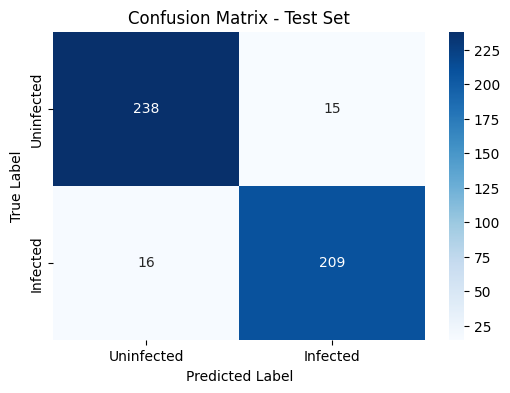

In [17]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def preload_data(dataset):
    all_inputs = []
    all_labels = []
    for i in range(len(dataset)):
        input, label = dataset[i]
        all_inputs.append(input)
        all_labels.append(label)
    return torch.stack(all_inputs), torch.tensor(all_labels)


print("Preloading test data...")
test_inputs, test_labels = preload_data(test_dataset)
test_loader = DataLoader(
    list(zip(test_inputs, test_labels)),
    batch_size=16,
    shuffle=False,
    num_workers=4
)


def evaluate_metrics(model, data_loader, device, set_name="Test"):
    model.eval()
    all_preds = []
    all_probs = []  # For AUC
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for positive class (infected)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)


    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)

    cm = confusion_matrix(all_labels, all_preds)


    print(f"\n{set_name} Set Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Uninfected', 'Infected'],
                yticklabels=['Uninfected', 'Infected'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Evaluating model on test set...")
evaluate_metrics(model, test_loader, device, set_name="Test")

## ROC CURVE

Preloading test data...
Evaluating model on test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Set Metrics:
Accuracy: 0.9351
Precision: 0.9330
Recall: 0.9289
F1 Score: 0.9310
AUC-ROC: 0.9801


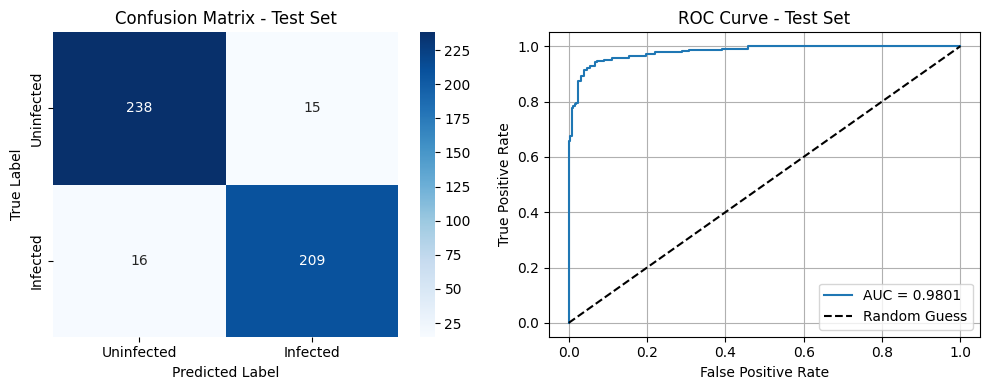

In [19]:


model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preload_data(dataset):
    all_inputs = []
    all_labels = []
    for i in range(len(dataset)):
        input, label = dataset[i]
        all_inputs.append(input)
        all_labels.append(label)
    return torch.stack(all_inputs), torch.tensor(all_labels)


print("Preloading test data...")
test_inputs, test_labels = preload_data(test_dataset)
test_loader = DataLoader(
    list(zip(test_inputs, test_labels)),
    batch_size=16,
    shuffle=False,
    num_workers=4
)


def evaluate_metrics(model, data_loader, device, set_name="Test"):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Get probabilities for AUC and ROC
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for positive class (infected)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)


    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)


    cm = confusion_matrix(all_labels, all_preds)


    print(f"\n{set_name} Set Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 4))


    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Uninfected', 'Infected'],
                yticklabels=['Uninfected', 'Infected'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {set_name} Set')
    plt.legend(loc='best')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("Evaluating model on test set...")
evaluate_metrics(model, test_loader, device, set_name="Test")

Model loaded successfully.
Image 1: Path = /content/drive/MyDrive/case/test/Parasitized/C39P4thinF_original_IMG_20150622_105335_cell_4.png, Predicted Class = Parasitized, Probability = 0.9038
Image 2: Path = /content/drive/MyDrive/case/test/Parasitized/C100P61ThinF_IMG_20150918_145938_cell_175.png, Predicted Class = Parasitized, Probability = 0.6589
Image 3: Path = /content/drive/MyDrive/case/test/Parasitized/C39P4thinF_original_IMG_20150622_110115_cell_136.png, Predicted Class = Parasitized, Probability = 0.7291
Image 4: Path = /content/drive/MyDrive/case/test/Parasitized/C39P4thinF_original_IMG_20150622_110115_cell_104.png, Predicted Class = Parasitized, Probability = 0.7410
Image 5: Path = /content/drive/MyDrive/case/test/Parasitized/C39P4thinF_original_IMG_20150622_110352_cell_84.png, Predicted Class = Parasitized, Probability = 0.7658
Image 6: Path = /content/drive/MyDrive/case/test/Uninfected/C2NThinF_IMG_20150604_114631_cell_150.png, Predicted Class = Parasitized, Probability = 

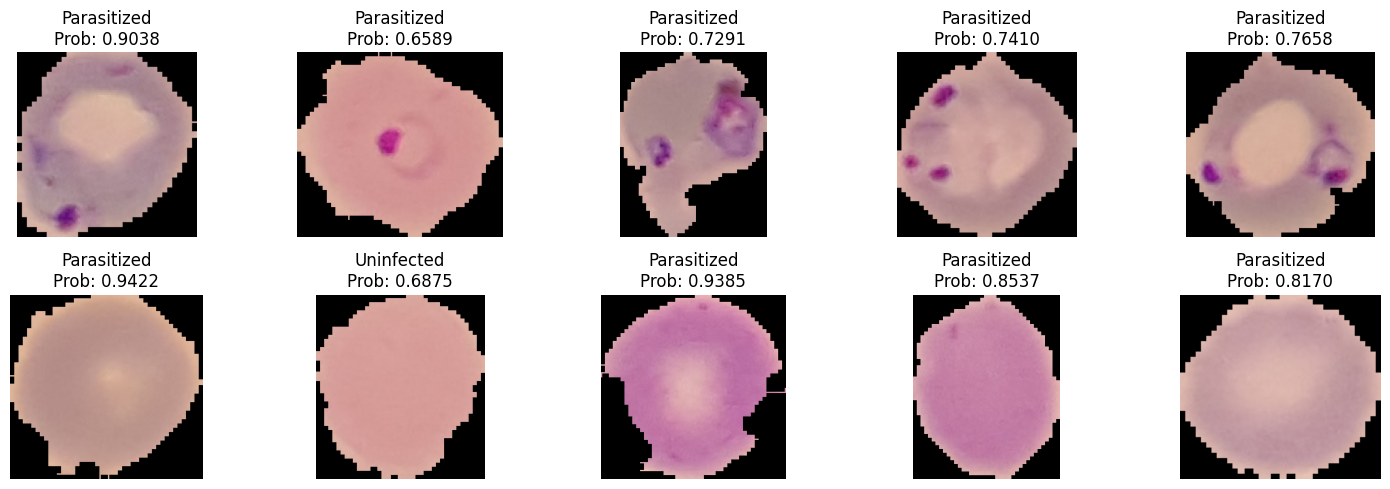


Total images tested: 10 (up to 5 from each class)


In [25]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

# Define the model class (trying ResNet-18 as the closest match)
class ResNetMalariaClassifier(nn.Module):
    def __init__(self):
        super(ResNetMalariaClassifier, self).__init__()
        self.resnet = models.resnet18(weights=None)  # Use ResNet-18, not pretrained
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)  t

    def forward(self, x):
        return self.resnet(x)

class TestImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            transformed_image = self.transform(image)
        else:
            transformed_image = image
        return transformed_image, image, img_path

data_dir = '/content/drive/MyDrive/case/test'
parasitized_dir = os.path.join(data_dir, 'Parasitized')
uninfected_dir = os.path.join(data_dir, 'Uninfected')
model_path = '/content/drive/MyDrive/case/resnet_malaria_model.pth'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

parasitized_images = [os.path.join(parasitized_dir, img) for img in os.listdir(parasitized_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
uninfected_images = [os.path.join(uninfected_dir, img) for img in os.listdir(uninfected_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

max_samples = 5
parasitized_images = random.sample(parasitized_images, min(max_samples, len(parasitized_images)))
uninfected_images = random.sample(uninfected_images, min(max_samples, len(uninfected_images)))


image_paths = parasitized_images + uninfected_images #Combines paths

test_dataset = TestImageDataset(image_paths, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetMalariaClassifier()
try:
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

model = model.to(device)
model.eval()

# For testing the model and display images
plt.figure(figsize=(15, 5))
for i in range(len(test_dataset)):
    transformed_image, raw_image, img_path = test_dataset[i]
    transformed_image = transformed_image.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted = torch.max(outputs, 1)
        pred_label = predicted.item()
        class_name = "Parasitized" if pred_label == 1 else "Uninfected"
        prob = torch.softmax(outputs, dim=1)[0][pred_label].item()

    # For displaying the image
    plt.subplot(2, 5, i + 1)
    # To convert PIL Image to numpy array for display
    img = np.array(raw_image)
    plt.imshow(img)
    plt.title(f"{class_name}\nProb: {prob:.4f}")
    plt.axis('off')
    print(f"Image {i+1}: Path = {img_path}, Predicted Class = {class_name}, Probability = {prob:.4f}")

plt.tight_layout()
plt.show()

print(f"\nTotal images tested: {len(image_paths)} (up to 5 from each class)")